In [11]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

### Preprocessing data

In [3]:
data_c = pd.read_parquet('./Local/2017_Clean/Combined.parquet')
data_f1 = pd.read_parquet('./Local/2017_Final/Combined_1.parquet')
data_f2 = pd.read_parquet('./Local/2017_Final/Combined_2.parquet')

datasets = {'Clean data': data_c, 'Final data 1': data_f1, 'Final data 2': data_f2}

In [4]:
def preprocess_data(df):
    label_encoder = LabelEncoder()
    label_col = 'Label' if 'Label' in df.columns else ' Label'
    df[label_col] = label_encoder.fit_transform(df[label_col])
    
    X = df.drop(label_col, axis=1)
    y = df[label_col]

    # Dimensionality reduction with PCA
    # 2 components for BENIGN/ATTACK  classification
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X)
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_reduced)

    # Converting to sparse matrix
    X_sparse = csr_matrix(X_scaled)
    
    X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.2, random_state=42)   
    return X_train, X_test, y_train, y_test

processed_datasets = {name: preprocess_data(df) for name, df in datasets.items()}

### Defining and running the model for each dataset

The time it takes to train the SVM model with the given code depends on several factors, when working with a large dataset, training time becomes a significant concern. To improve the speed of training process a several significant changes were made:
- Dimensionality Reduction with PCA: Reduced features to 2 principal components for detecting BENIGN/ATTACK data. (More details about PCA can be found in K-Means implementation)
- Linear SVM (LinearSVC): Switched from a kernel-based SVM to a linear SVM for faster training. Downside: effectiveness will decrease!

In [13]:
def linear_svm_model(C=1.0, max_iter=5000):
    print(f"Creating Linear SVM model with C={C} and max_iter={max_iter}")
    return LinearSVC(C=C, max_iter=max_iter, random_state=42)

--- Clean data ---
Creating Linear SVM model with C=1.0
Train accuracy: 0.8797
Test accuracy: 0.8793

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94    429322
           1       0.00      0.00      0.00       408
           2       0.00      0.00      0.00     25511
           3       0.00      0.00      0.00      2025
           4       0.77      0.80      0.78     34698
           5       0.00      0.00      0.00      1017
           6       0.00      0.00      0.00      1113
           7       0.00      0.00      0.00      1182
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         7
          10       0.00      0.00      0.00     18185
          11       0.00      0.00      0.00       638
          12       0.00      0.00      0.00       289
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00       126

    accur

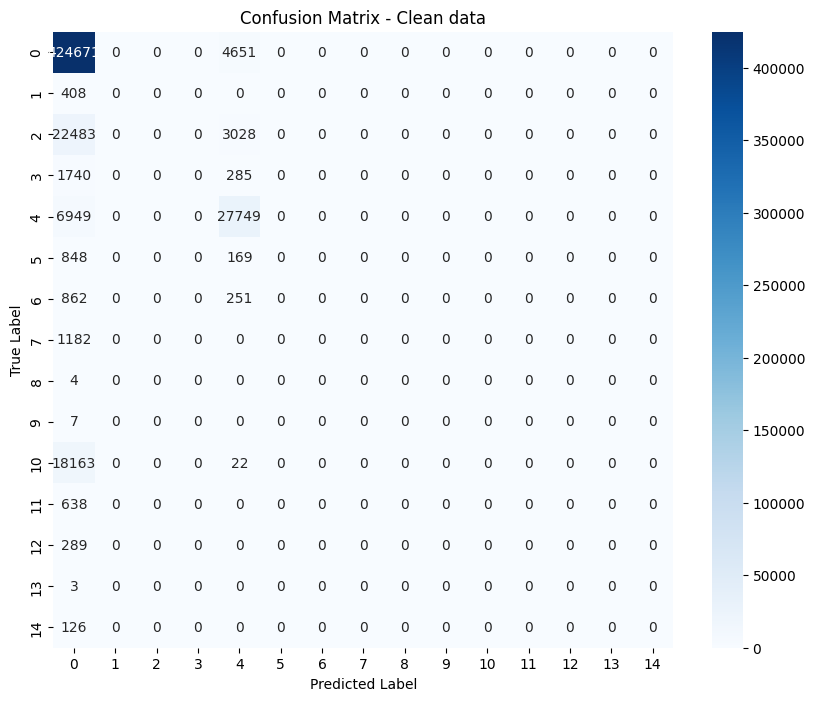

--- Final data 1 ---
Creating Linear SVM model with C=1.0
Train accuracy: 0.8550
Test accuracy: 0.8546

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93    858235
           1       0.00      0.00      0.00       788
           2       0.53      0.43      0.47     51582
           3       0.00      0.00      0.00      4042
           4       0.48      0.05      0.10     69311
           5       0.00      0.00      0.00      2168
           6       0.00      0.00      0.00      2068
           7       0.00      0.00      0.00      2371
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00     36371
          11       0.00      0.00      0.00      1253
          12       0.00      0.00      0.00       572
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00       270

    acc

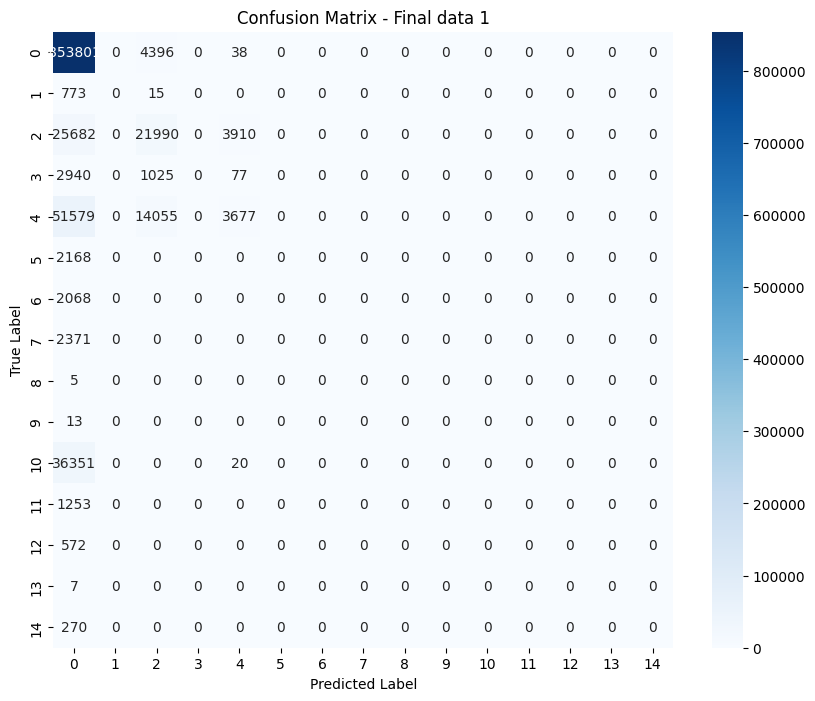

--- Final data 2 ---
Creating Linear SVM model with C=1.0
Train accuracy: 0.8550
Test accuracy: 0.8546

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.93    858235
           1       0.00      0.00      0.00       788
           2       0.53      0.43      0.47     51582
           3       0.00      0.00      0.00      4042
           4       0.48      0.05      0.10     69311
           5       0.00      0.00      0.00      2168
           6       0.00      0.00      0.00      2068
           7       0.00      0.00      0.00      2371
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        13
          10       0.00      0.00      0.00     36371
          11       0.00      0.00      0.00      1253
          12       0.00      0.00      0.00       572
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00       270

    acc

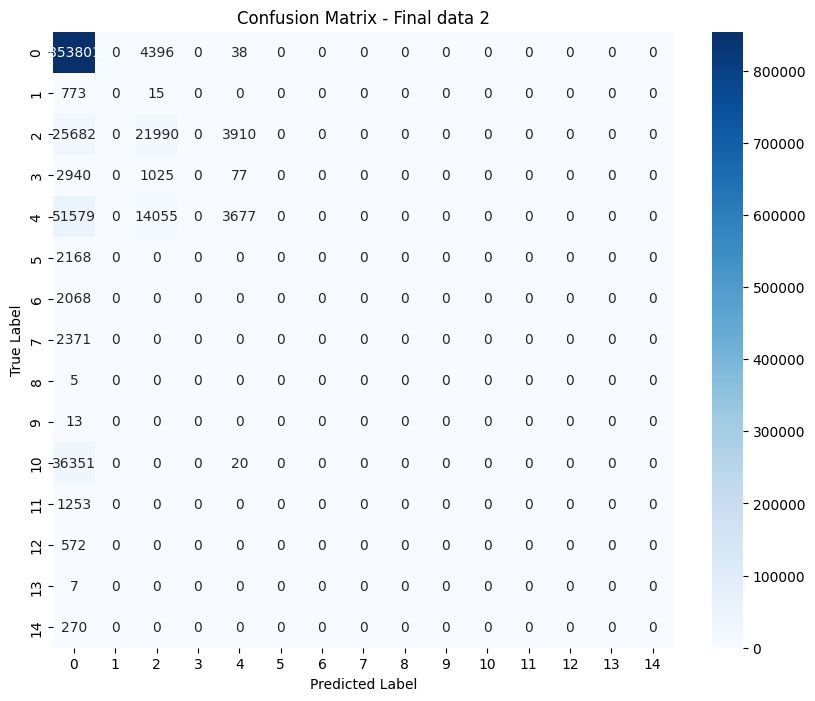

In [8]:
for name, (X_train, X_test, y_train, y_test) in processed_datasets.items():
    print(f'--- {name} ---')
    
    svm_model = linear_svm_model()
    svm_model.fit(X_train, y_train)
    
    # Evaluate the model
    train_accuracy = svm_model.score(X_train, y_train)
    test_accuracy = svm_model.score(X_test, y_test)
    print(f"Train accuracy: {train_accuracy:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    y_pred = svm_model.predict(X_test)
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Hyperparameter tuning

In [14]:
def tune_svm_hyperparameters(X_train, y_train):    
    param_grid = {
        'C': [0.1, 1, 10, 100],
    }
    
    svm_model = linear_svm_model()
    grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters found:", grid_search.best_params_)
    return grid_search.best_estimator_

--- Clean data ---
Creating Linear SVM model with C=1.0 and max_iter=5000
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..............................................C=100; total time= 1.0min
[CV] END ...............................................C=10; total time= 1.2min
[CV] END ...............................................C=10; total time= 1.2min
[CV] END ..............................................C=0.1; total time= 1.2min
[CV] END ..............................................C=0.1; total time= 1.2min
[CV] END ................................................C=1; total time= 1.2min
[CV] END ................................................C=1; total time= 1.2min
[CV] END ..............................................C=0.1; total time= 1.3min
[CV] END ..............................................C=100; total time= 1.3min
[CV] END ...............................................C=10; total time= 1.3min
[CV] END ..............................................C

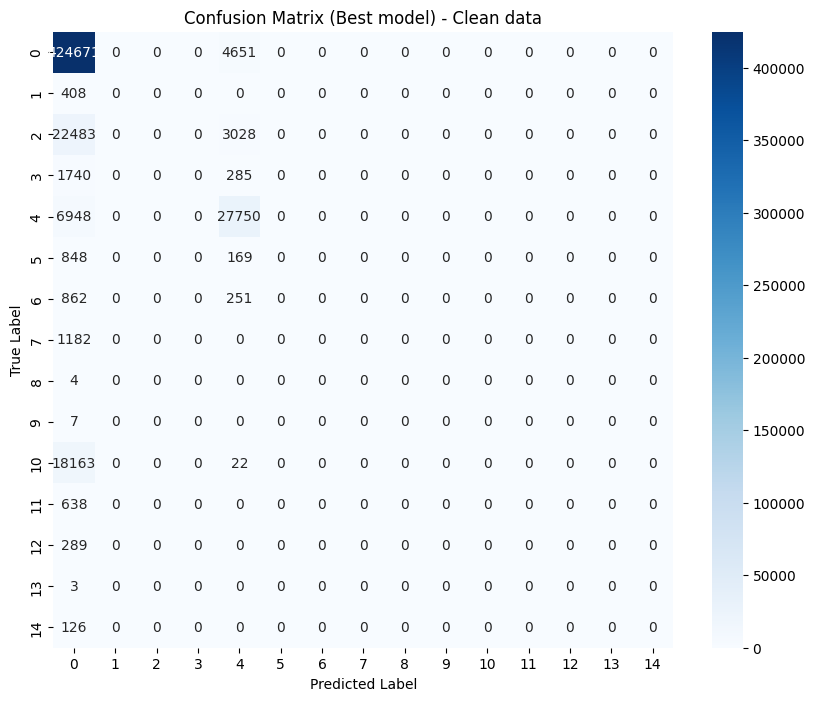

--- Final data 1 ---
Creating Linear SVM model with C=1.0 and max_iter=5000
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..............................................C=0.1; total time= 3.9min
[CV] END ................................................C=1; total time= 4.5min
[CV] END ..............................................C=0.1; total time= 4.6min
[CV] END ...............................................C=10; total time= 4.7min
[CV] END ...............................................C=10; total time= 4.9min
[CV] END ..............................................C=100; total time= 5.1min
[CV] END ..............................................C=100; total time= 5.8min
[CV] END ..............................................C=0.1; total time= 6.2min
[CV] END ...............................................C=10; total time=14.1min
[CV] END ................................................C=1; total time=15.8min
[CV] END .............................................

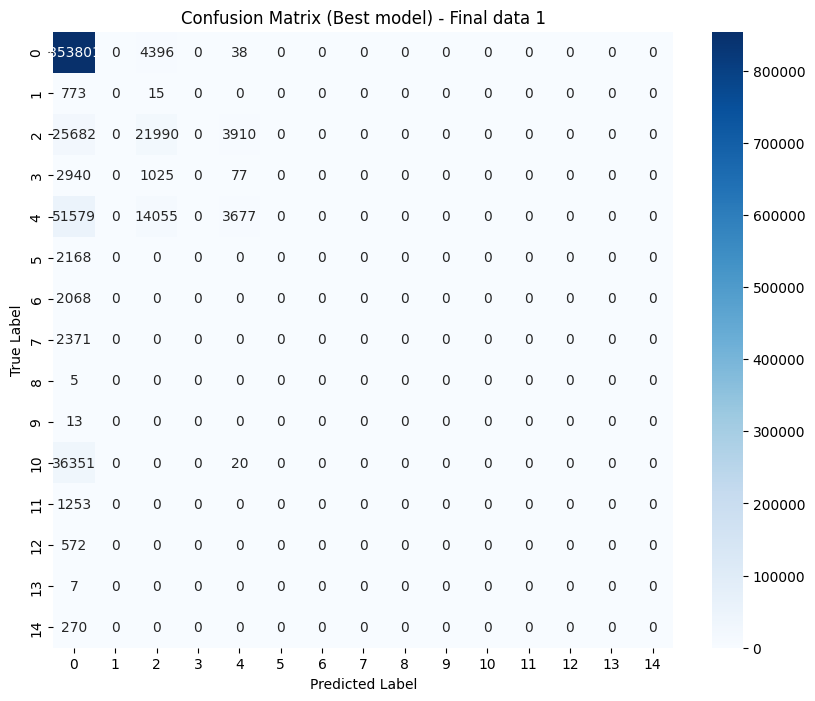

--- Final data 2 ---
Creating Linear SVM model with C=1.0 and max_iter=5000
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ..............................................C=0.1; total time= 3.7min
[CV] END ................................................C=1; total time= 4.4min
[CV] END ..............................................C=0.1; total time= 4.8min
[CV] END ...............................................C=10; total time= 4.9min
[CV] END ...............................................C=10; total time= 4.9min
[CV] END ..............................................C=100; total time= 5.1min
[CV] END ..............................................C=0.1; total time= 7.5min
[CV] END ...............................................C=10; total time=18.1min
[CV] END ................................................C=1; total time=19.5min
[CV] END ................................................C=1; total time=22.9min
[CV] END .............................................

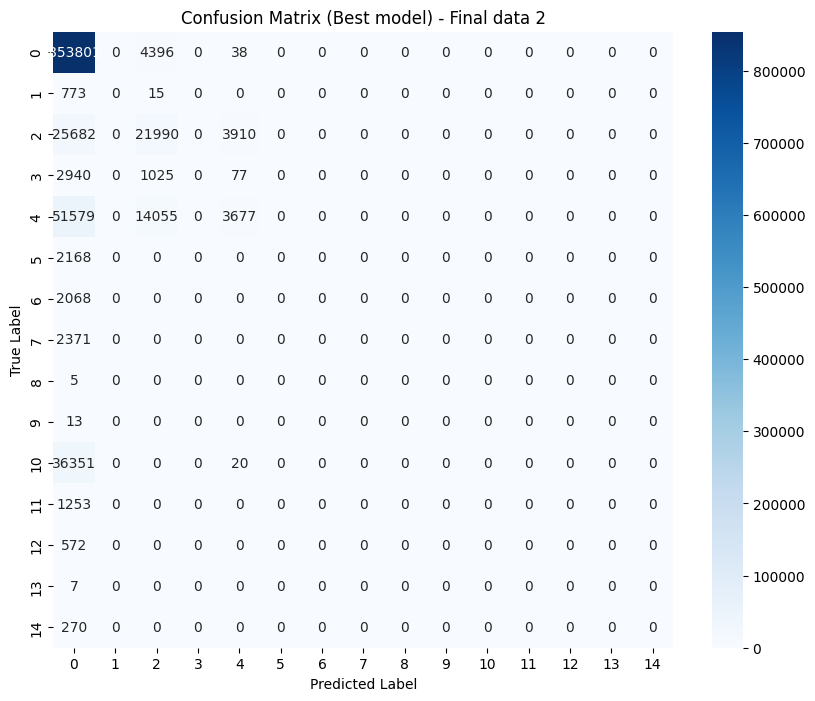

In [15]:
for name, (X_train, X_test, y_train, y_test) in processed_datasets.items():
    print(f'--- {name} ---')
    
    best_model = tune_svm_hyperparameters(X_train, y_train)
    
    # Evaluate the best model
    train_accuracy = best_model.score(X_train, y_train)
    test_accuracy = best_model.score(X_test, y_test)
    print(f"Best model - Train accuracy: {train_accuracy:.4f}")
    print(f"Best model - Test accuracy: {test_accuracy:.4f}")
    
    y_pred = best_model.predict(X_test)
    
    print("\nClassification Report (Best model):")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix (Best model) - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()